### Analyse der Wortfrequenzen zu BVG, HVV und MVG in Medienberichten

Dieses Notebook liefert eine quantitativ-explorative Übersicht über die Wortfrequenzen zu den Verkehrsunternehmen Berliner Verkehrsbetriebe (BVG), Hamburger Verkehrsverbund (HVV) und Münchner Verkehrsgesellschaft (MVG).

Es handelt sich um eine erste grobe Analyse auf Aggregationsebene, in der anhand einfacher Zählungen untersucht wird, wie häufig die Begriffe BVG, HVV und MVG in verschiedenen Medienquellen und Jahren vorkommen.  
Dabei werden alle Wörter aus dem gesammelten HTML-Seiteninhalt einbezogen, unabhängig vom inhaltlichen Kontext oder ihrer Platzierung im Text.

Visualisierungen umfassen:
- Häufigkeit nach Medium und Jahr (Heatmaps, gruppierte Balkendiagramme)  
- Jahresbezogene Wordclouds für Begriffe wie BVG, HVV und MVG

#### 1. Import benötigte Pakete

In [46]:
# Standard
import os # Dateipfaden
import pandas as pd # Datenanalyse
import sqlite3  # Speicherung in SQLite-Datenbanken
from datetime import datetime # Datumsangaben

# Visualisierung
import seaborn as sns # Statistische Diagramme
import matplotlib.pyplot as plt # Diagrammerstellung 
from wordcloud import WordCloud # Wortwolken 

# Eigene Funktionen (ausgelagert)
import sys  # Systemfunktionen 
sys.path.append("../scripts") # Pfad zu den Funktionen
# Funktionen aus wortfrequenz.py importieren
from wortfrequenz import analyse_wortformen

In [47]:
# Pfade
# Projektverzeichnis 
PROJECT_ROOT = r"D:/DBU/ADSC11 ADS-01/Studienarbeit/newspaper-scraping"

# Output-Pfad
OUTPUT_PATH = os.path.join(PROJECT_ROOT, "output") 

# Datei für die Analyse
DATAPATH = os.path.join(OUTPUT_PATH, "wordcount_news.csv")

#### 2. Datenexploration

In [48]:
# CSV-Dateien  einlesen
df_medien = pd.read_csv(DATAPATH)

In [49]:
# Anzahl Zeilen und Spalten
df_medien.shape

(48129140, 5)

In [50]:
# Spaltennamen
df_medien.columns

Index(['count', 'word', 'source', 'date', 'cluster'], dtype='object')

In [51]:
# Überblick Datentypen
df_medien.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48129140 entries, 0 to 48129139
Data columns (total 5 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   count    int64 
 1   word     object
 2   source   object
 3   date     object
 4   cluster  object
dtypes: int64(1), object(4)
memory usage: 1.8+ GB


In [52]:
# Statistischen Merkmale für numerische Spalten 
df_medien.describe()

,count
count,4.812914e+07
mean,1.540547e+00
std,2.999903e+00
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,1.000000e+00
max,2.470000e+02


In [53]:
# Prüfung fehlende Werte
df_medien.isnull().sum()

count         0
word       1951
source        0
date          0
cluster       0
dtype: int64

In [54]:
# Fehlende Wörter nach Medium
df_medien[df_medien["word"].isna()]["source"].value_counts()

source
sz              274
zeit            187
boerse          183
ntv             182
heise           148
welt            120
stern           110
tagesspiegel     92
spiegel          85
taz              84
berliner         80
faz              78
mm               71
wiwo             60
dlf              51
netzpolitik      44
handelsblatt     41
tagesschau       31
abendblatt       18
dw-de             8
pioneer           4
Name: count, dtype: int64

In [55]:
# Neue Spalte Jahr
df_medien["date"] = pd.to_datetime(df_medien["date"])  
df_medien["year"] = df_medien["date"].dt.year.astype(int)  # Jahre als ganze Zahlen anzeigen

In [56]:
# Prüfung
df_medien.columns

Index(['count', 'word', 'source', 'date', 'cluster', 'year'], dtype='object')

In [57]:
# Fehlende Wörter nach Jahr 
df_medien[df_medien["word"].isna()]["year"].value_counts().sort_index()

year
2021    561
2022    546
2023    268
2024    376
2025    200
Name: count, dtype: int64

In [58]:
# 5 zufällige Beispiele für NaN in "word"
df_medien[df_medien["word"].isna()].sample(5)

,count,word,source,date,cluster,year
29225178,1,NaN,welt,2024-11-21,Große Medien,2024
36521282,1,NaN,berliner,2024-11-04,Regional,2024
29268576,3,NaN,zeit,2024-11-25,Große Medien,2024
37585817,1,NaN,ntv,2021-06-29,Digital,2021
13190822,1,NaN,stern,2021-08-20,Große Medien,2021


In [59]:
# Fehlende Werte löschen, weil sie keine Infos enthalten
df_medien = df_medien[df_medien["word"].notna()]

#### 3. Wortfrequenzanalyse

##### 3.1 Häufigkeit der exakten Begriffe BVG, HVV und MVG 

In [60]:
# Häufigkeit der Begriffe BVG, MVG, HVV in den ausgewählten Medien
treffer = df_medien[df_medien["word"].isin(["bvg", "mvg", "hvv"])]

# Absolute Häufigkeiten
wert_counts = treffer["word"].value_counts()

# Relative Häufigkeiten bezogen auf die drei Begriffe
wert_prozent = wert_counts / wert_counts.sum() * 100

# Ergebnis anzeigen
print("Anzahl der Begriffe BVG, MVG, HVV:")
print(wert_counts)
print("Anteil der Begriffe BVG, MVG, HVV in %:")
print(wert_prozent.round(2))

Anzahl der Begriffe BVG, MVG, HVV:
word
bvg    1363
hvv     564
mvg     125
Name: count, dtype: int64
Anteil der Begriffe BVG, MVG, HVV in %:
word
bvg    66.42
hvv    27.49
mvg     6.09
Name: count, dtype: float64


In [61]:
# Häufigkeit der Begriffe BVG, MVG, HVV nach Jahren
# Gruppierung: Nennungen je Jahr und Begriff summieren
oepnv_jahre = treffer.groupby(["year", "word"])["count"].sum().unstack().fillna(0).astype(int)

# Anzeigen
print(oepnv_jahre)

word  bvg  hvv  mvg
year               
2021  487   35   41
2022  497  407   65
2023  343  165   16
2024  513  165   17
2025  300   35    2


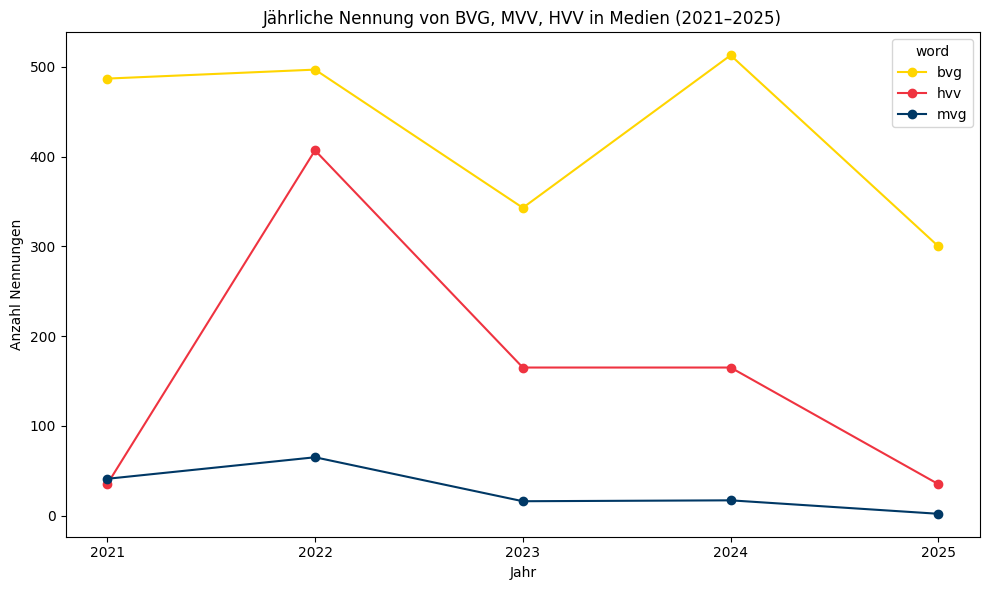

In [62]:
# Plot: Liniendiagramm Häufigkeit der Begriffe BVG, MVG, HVV nach Jahren
# Vorbereitung
# Farbdefinitionen nach CI der Verkerhsunternehmen
bvg_color = "#FFD500" # BVG-Gelb
mvv_color = "#003865" # MVV-Blau
hvv_color = "#EF3340" # HVV-Rot

# Dictionary für die CI-Farben
farben = {
    "bvg": bvg_color,
    "mvg": mvv_color,
    "hvv": hvv_color
}

# Kombination Verkehrsunternehmen und Jahr
ax = oepnv_jahre.plot(
    kind="line",
    marker="o",
    figsize=(10, 6),
    color=[farben[col] for col in oepnv_jahre.columns]  # Farbenzuteilung pro Spalte
)

# Plot Formatierung: Titel, Achsen, Layout 
plt.title("Jährliche Nennung von BVG, MVV, HVV in Medien (2021–2025)")
plt.ylabel("Anzahl Nennungen")
plt.xlabel("Jahr")
plt.grid(False)
plt.xticks(ticks=oepnv_jahre.index, labels=oepnv_jahre.index.astype(int)) 
plt.tight_layout()
plt.show()

In [63]:
# Häufigkeit der Begriffe BVG, MVG, HVV nach Medien
# Gruppierung: Häufigkeit der Begriffe je Medium und Begriff summieren
oepnv_quellen = treffer.groupby(["source", "word"])["count"].sum().unstack().fillna(0).astype(int)
# in %
oepnv_quellen_prozent = oepnv_quellen.div(oepnv_quellen.sum(axis=1), axis=0) * 100

# Anzeigen
print(oepnv_quellen.sort_index())
print(oepnv_quellen_prozent.round(2).sort_index()) # 2 Kommastellen

word           bvg  hvv  mvg
source                      
abendblatt       2  796    0
berliner       742    0    0
boerse           0    0  116
dlf              1    0    0
faz              4    0    0
heise            7    0    0
mm               8    0    0
ntv             16    3    1
spiegel          9    0    0
stern            7    2    0
sz               4    1   23
t3n              6    0    0
tagesspiegel  1219    0    0
taz             94    0    0
welt            11    1    1
zeit            10    4    0
word             bvg    hvv     mvg
source                             
abendblatt      0.25  99.75    0.00
berliner      100.00   0.00    0.00
boerse          0.00   0.00  100.00
dlf           100.00   0.00    0.00
faz           100.00   0.00    0.00
heise         100.00   0.00    0.00
mm            100.00   0.00    0.00
ntv            80.00  15.00    5.00
spiegel       100.00   0.00    0.00
stern          77.78  22.22    0.00
sz             14.29   3.57   82.14
t3n       

In [64]:
# Häufigkeit der Begriffe BVG, MVG, HVV nach Medien und Jahren
# Pivot-Tabelle für bessere Lesbarkeit
for wort in ["bvg", "mvg", "hvv"]:
    df_tmp = treffer[treffer["word"] == wort]
    pivot = df_tmp.pivot_table(index="year", columns="source", values="count", aggfunc="sum", fill_value=0)
    print(f"\nPivot-Tabelle für {wort.upper()}:")
    display(pivot)


Pivot-Tabelle für BVG:


source,abendblatt,berliner,dlf,faz,heise,mm,ntv,spiegel,stern,sz,t3n,tagesspiegel,taz,welt,zeit
year,,,,,,,,,,,,,,,
2021,0,70,0,0,1,0,0,0,3,0,0,406,7,0,0
2022,0,69,0,2,0,0,1,5,1,0,0,410,7,1,1
2023,2,160,0,0,1,8,0,0,0,1,6,138,27,0,0
2024,0,288,0,0,3,0,4,2,2,2,0,174,31,5,2
2025,0,155,1,2,2,0,11,2,1,1,0,91,22,5,7



Pivot-Tabelle für MVG:


source,boerse,ntv,sz,welt
year,,,,
2021,37,0,3,1
2022,60,0,5,0
2023,4,0,12,0
2024,15,0,2,0
2025,0,1,1,0



Pivot-Tabelle für HVV:


source,abendblatt,ntv,stern,sz,welt,zeit
year,,,,,,
2021,33,2,0,0,0,0
2022,403,0,0,0,0,4
2023,164,0,1,0,0,0
2024,161,1,1,1,1,0
2025,35,0,0,0,0,0


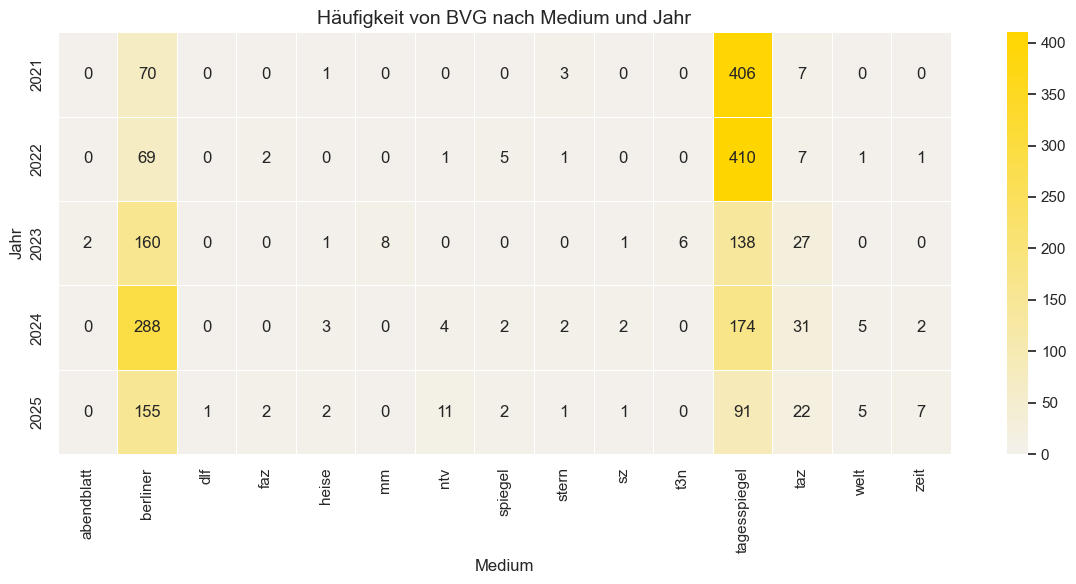

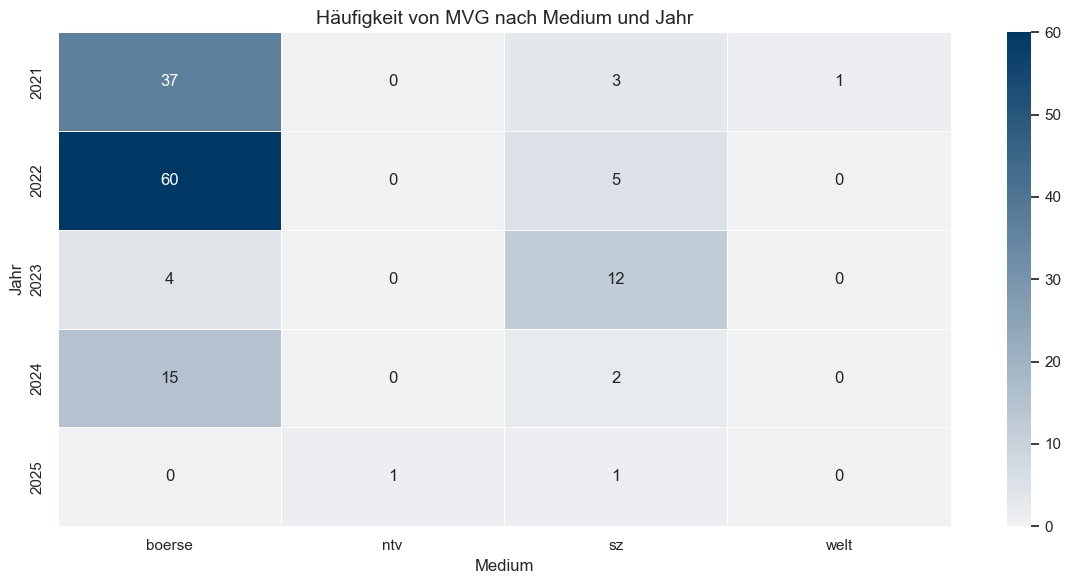

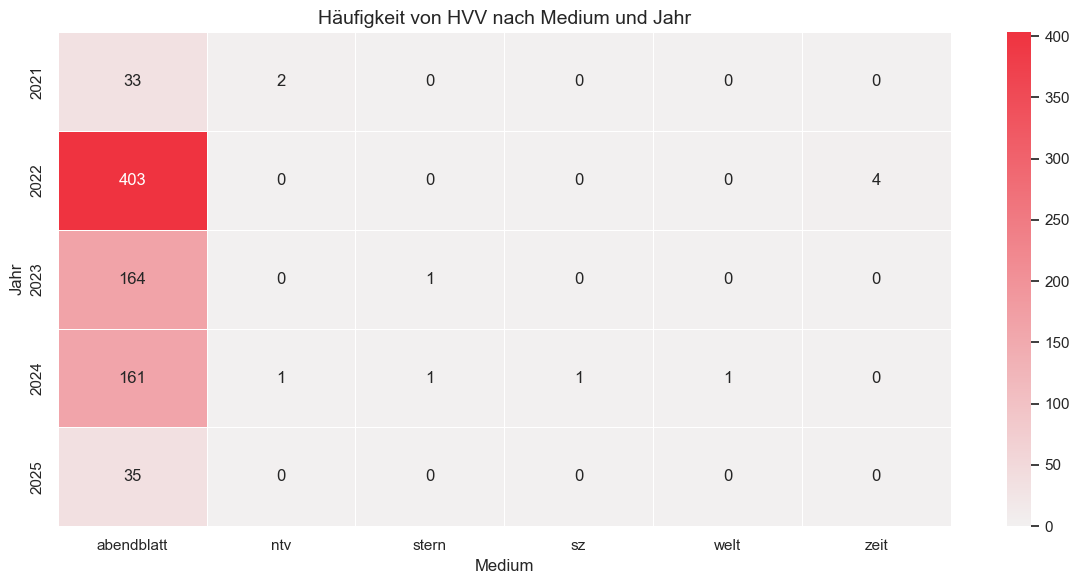

In [65]:
# Plot: Heatmap Häufigkeit der Begriffe BVG, MVG, HVV nach Medien und Jahren
# Vorbereitung
sns.set_theme(style="whitegrid")

# Schleife über die Verkehrsunternehmen
for wort in ["bvg", "mvg", "hvv"]:
    # Filtern
    df_tmp = treffer[treffer["word"] == wort]

    # Pivot-Tabelle: Zeilen = Jahr, Spalten = Medium
    pivot = df_tmp.pivot_table(index="year", columns="source", values="count", aggfunc="sum", fill_value=0)

    # Heatmap zeichnen
    plt.figure(figsize=(12, 6))
    cmap_farbe = farben.get(wort, "gray")

    # Farbschema auf Basis einer Einzelfarbe
    sns.heatmap(pivot, cmap=sns.light_palette(cmap_farbe, as_cmap=True), annot=True, fmt="d", linewidths=0.5)

    # Plot Formatierung: Titel, Achsen, Layout 
    plt.title(f"Häufigkeit von {wort.upper()} nach Medium und Jahr", fontsize=14)
    plt.xlabel("Medium")
    plt.ylabel("Jahr")
    plt.tight_layout()
    plt.show()

##### 3.1 Häufigkeit der exakten Begriffe BVG, HVV und MVG nach Clustern

In [66]:
# Häufigkeit nach Cluster und Begriff
häufigkeiten = treffer.groupby(["cluster", "word"]).size().unstack(fill_value=0)

# Ergebnisse anzeigen
print(häufigkeiten)

word                   bvg  hvv  mvg
cluster                             
Digital                 15    3    1
Große Medien           114    8   22
Regional              1213  553    0
Technologie             12    0    0
Wirtschaft               8    0  102
Öffentlich-rechtlich     1    0    0


In [67]:
# Pivot-Tabelle: Häufigkeit der Begriffe BVG, MVG, HVV nach Jahr und Cluster
pivot_cluster = treffer.groupby(["year", "cluster", "word"])["count"] \
    .sum().unstack().fillna(0).astype(int)

# Ergebnisse anzeigen
display(pivot_cluster)

word                       bvg  hvv  mvg
year cluster                            
2021 Digital                 0    2    0
     Große Medien           10    0    4
     Regional              476   33    0
     Technologie             1    0    0
     Wirtschaft              0    0   37
2022 Digital                 1    0    0
     Große Medien           17    4    5
     Regional              479  403    0
     Wirtschaft              0    0   60
2023 Große Medien           28    1   12
     Regional              300  164    0
     Technologie             7    0    0
     Wirtschaft              8    0    4
2024 Digital                 4    1    0
     Große Medien           44    3    2
     Regional              462  161    0
     Technologie             3    0    0
     Wirtschaft              0    0   15
2025 Digital                11    0    1
     Große Medien           40    0    1
     Regional              246   35    0
     Technologie             2    0    0
     Öffentlich-rechtlich    1    0    0

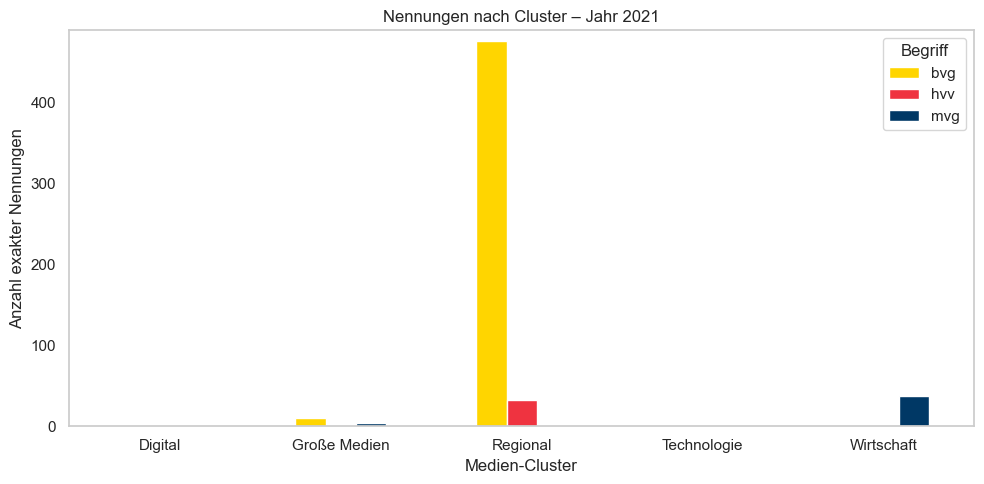

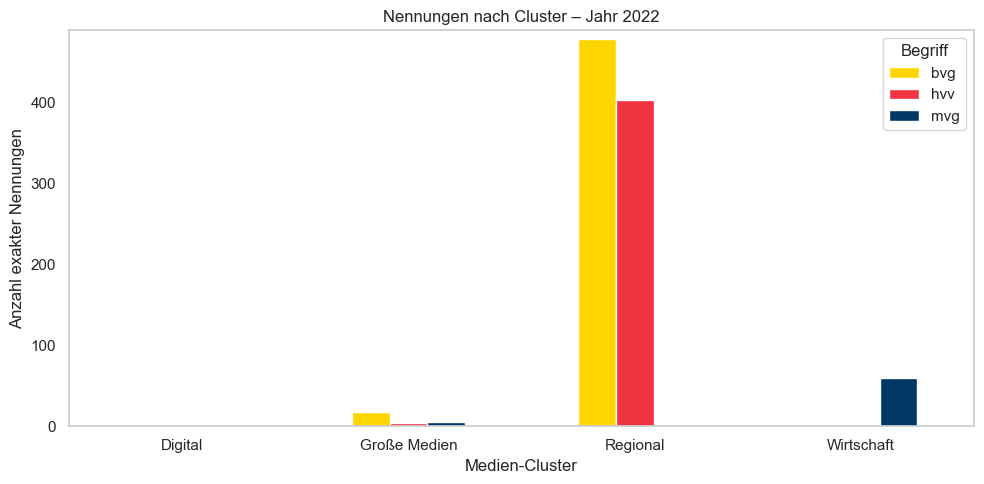

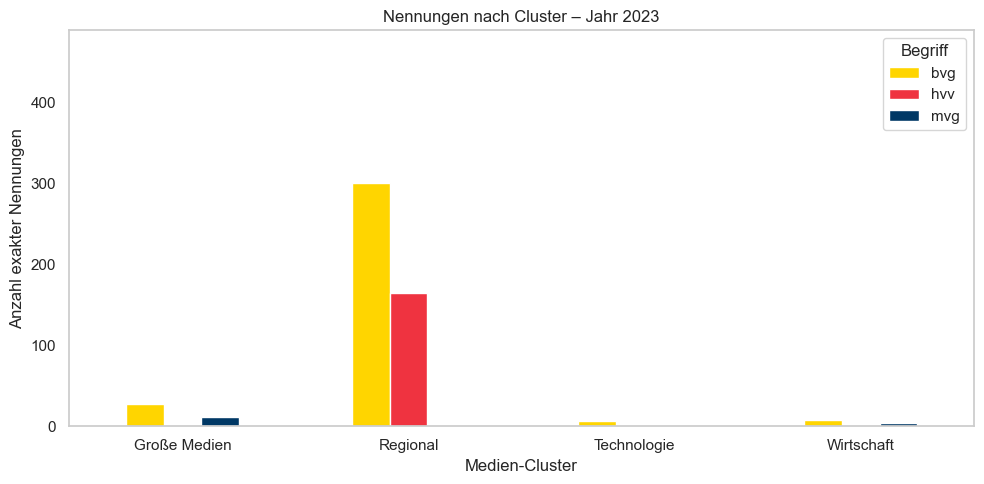

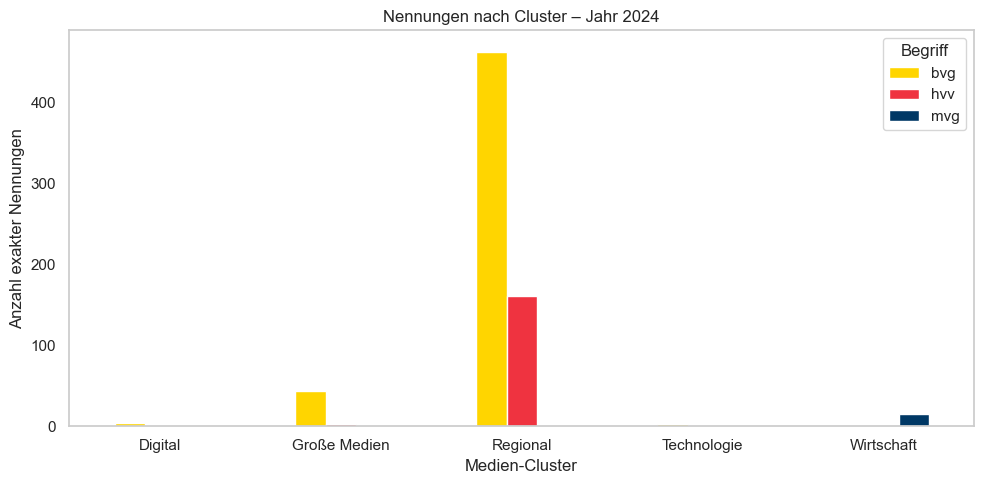

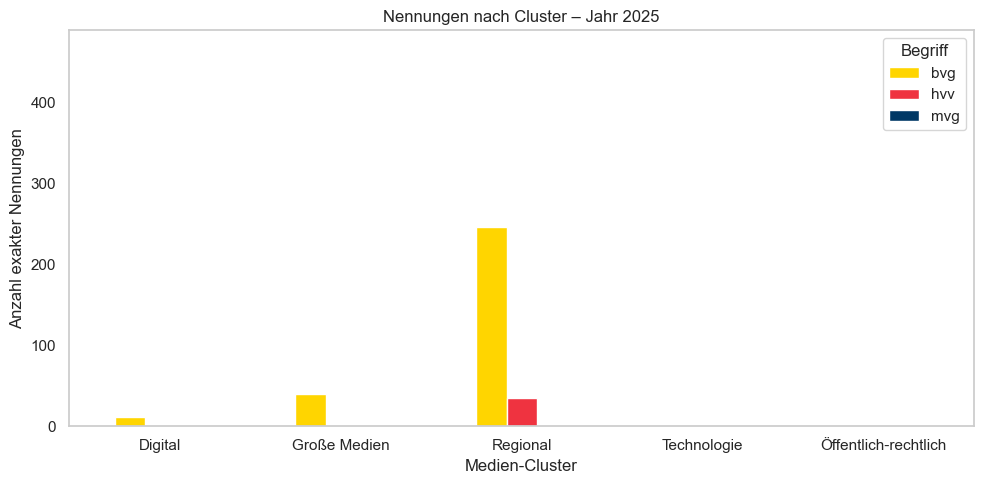

In [68]:
# Plot: Gruppiertes Balkendiagramm Häufigkeit der Begriffe BVG, MVG, HVV nach Medien-Clustern und Jahren
# Vorbereitung
# Liste aller Jahre im Datensatz
jahre = pivot_cluster.index.get_level_values("year").unique()

# Gleiche Skalierung für alle Balkendiagramme
# Maximalwert über alle Jahre & Begriffe
max_wert = pivot_cluster.max().max()

# Für jedes Jahr Balkendiagramm nach Medien-Clustern und Begriffen erzeugen
for year in jahre:
    df_plot = pivot_cluster.loc[year]

    # Gruppiertes Balkendiagramm
    ax = df_plot.plot(
        kind="bar",
        figsize=(10, 5),
        color=[farben.get(k, "gray") for k in df_plot.columns]
    )

    # Plot Formatierung: Titel, Achsen, Layout 
    plt.title(f"Nennungen nach Cluster – Jahr {year}")
    plt.ylabel("Anzahl exakter Nennungen")
    plt.xlabel("Medien-Cluster")
    plt.xticks(rotation=0)  # Beschriftung horizontal
    plt.ylim(0, max_wert + 10) # Skalierung mit Puffer
    plt.legend(title="Begriff")
    plt.tight_layout()
    plt.grid(False)
    plt.show()

##### 3.2 Wortformen mit den Begriffen BVG, HVV und MVG  

In [69]:
# Wortformen, die BVG, MVG oder HVV beinhalten 
df_oepnv = df_medien[df_medien["word"].str.contains("bvg|mvg|hvv", na=False)]
print("Häufigkeit der Wortformen BVG, MVG, HVV:")
print(df_oepnv["word"].value_counts())

Häufigkeit der Wortformen BVG, MVG, HVV:
word
bvg                  1363
hvv                   564
bvg:                  219
mvg                   125
bvg-bus                81
                     ... 
bvg-busknoten.          1
bvg-knoten              1
bvg-wartehäuschen       1
bvg-mitarbeitern.       1
bvg-vorständin          1
Name: count, Length: 276, dtype: int64


In [70]:
# Häufigkeit der Wortformen exportieren
word_counts = df_oepnv["word"].value_counts()
word_counts.to_csv(os.path.join(OUTPUT_PATH, "oepnv_wortformen_haeufigkeit.csv"))

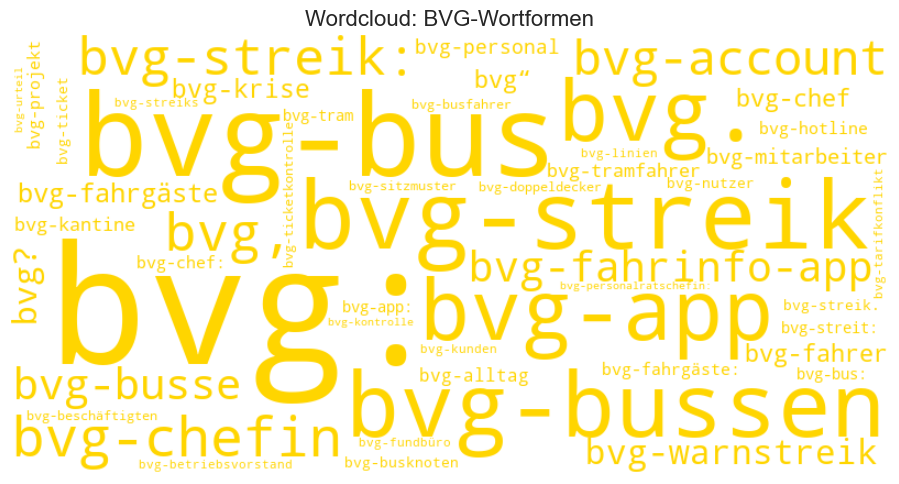

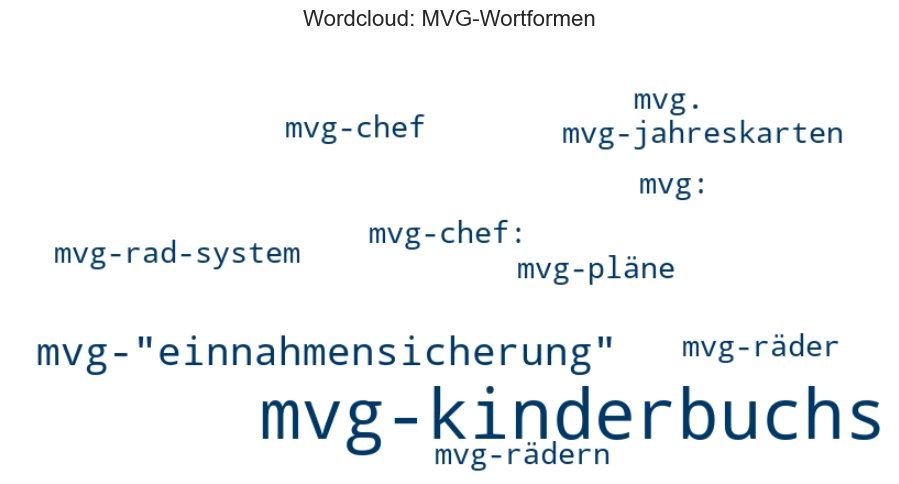

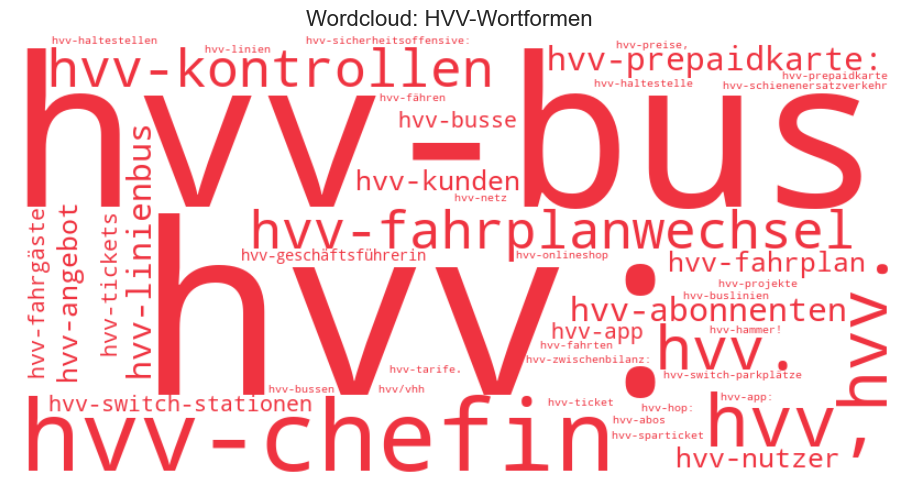

In [71]:
# Plot: Wordclouds für Wortformen, die mit BVG, MVG oder HVV beginnen (alle Jahre zusammengefasst)
# Vorbereitung
# Begriffsliste
begriffsliste = ["bvg", "mvg", "hvv"]

# Für jeden Begriff eine Wordcloud generieren
for begriff in begriffsliste:
    # Filter: alle Wörter, die mit BVG-, MVG- oder HVV- beginnen 
    # exakte Begriffe ausschließen
    df_wortformen = df_medien[
        (df_medien["word"].str.startswith(begriff, na=False)) & 
        (df_medien["word"] != begriff)
    ]

    # Häufigkeit je Wortform summieren
    wortformen = df_wortformen.groupby("word")["count"].sum().sort_values(ascending=False).head(50)
    # für Wordcloud in Dictionary umwandeln
    wort_dict = wortformen.to_dict()

    # CI-Farben 
    farbe = farben.get(begriff, "#000000")

    # Wordcloud erzeugen 
    wordcloud = WordCloud(
        width=800, height=400,
        background_color="white",
        color_func=lambda *args, **kwargs: farbe
    ).generate_from_frequencies(wort_dict)

    # Plot Formatierung: Titel, Achsen, Layout  
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Wordcloud: {begriff.upper()}-Wortformen", fontsize=16)
    plt.tight_layout()
    plt.show()

BVG 2021: 44 Wortformen gefunden.


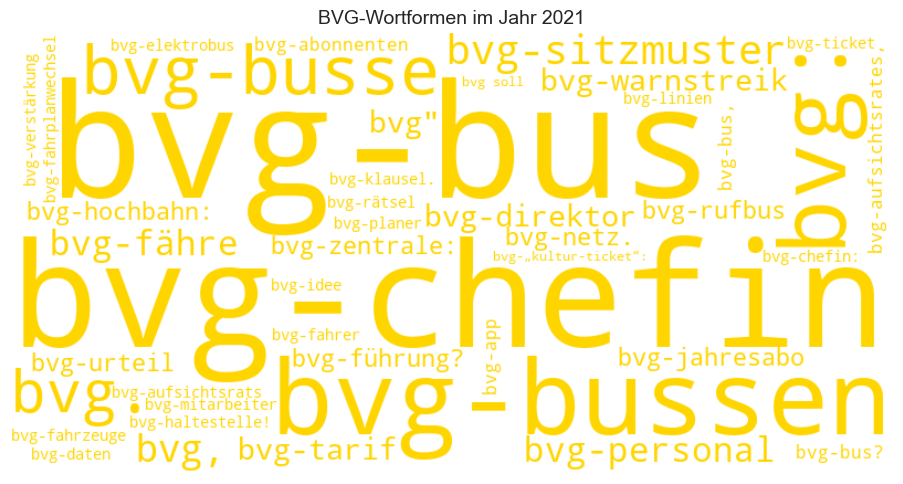

BVG 2022: 49 Wortformen gefunden.


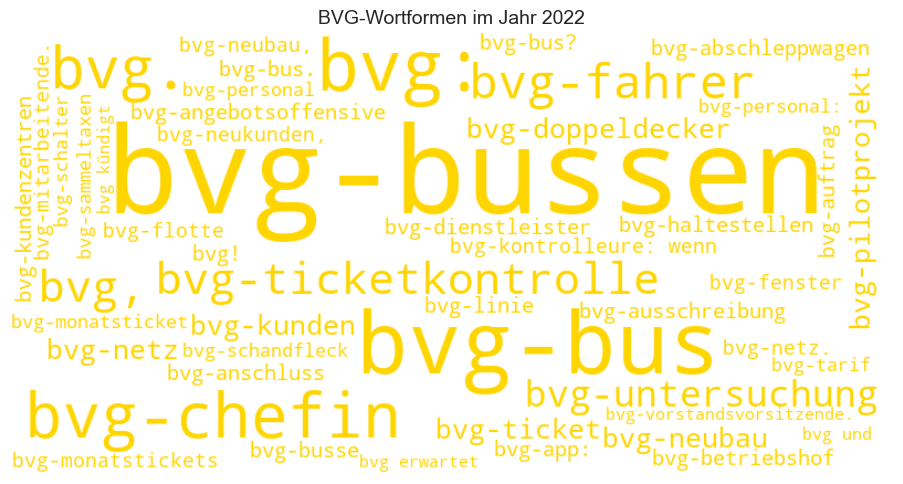

BVG 2023: 50 Wortformen gefunden.


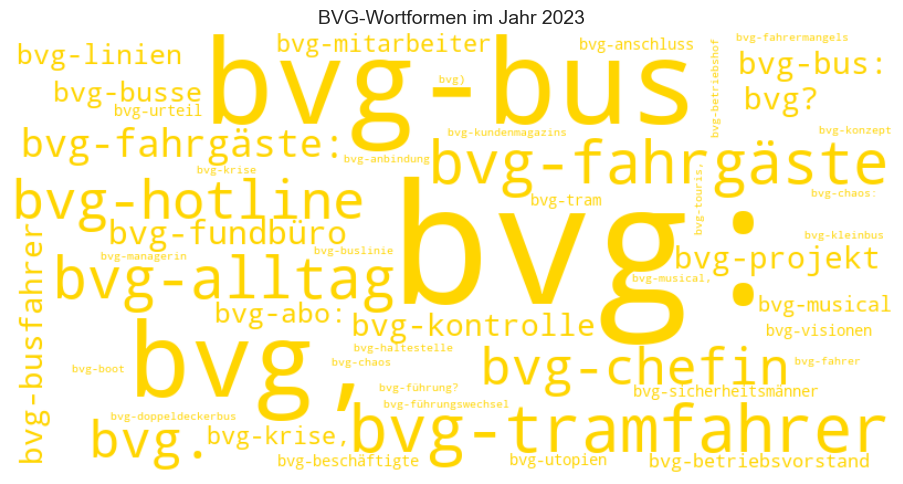

BVG 2024: 50 Wortformen gefunden.


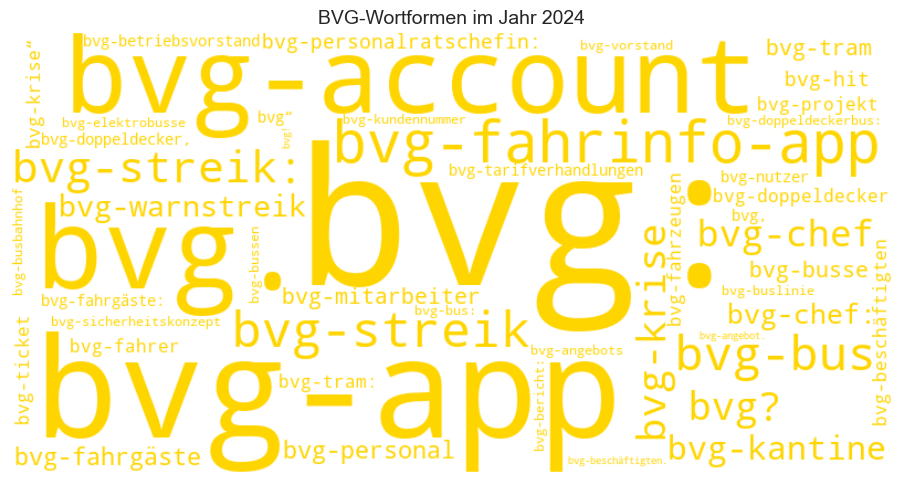

BVG 2025: 50 Wortformen gefunden.


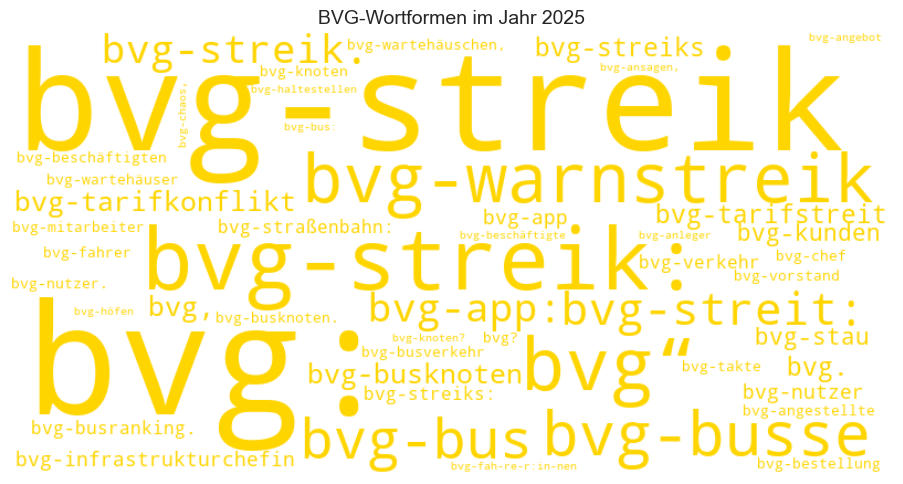

MVG 2021: 1 Wortformen gefunden.


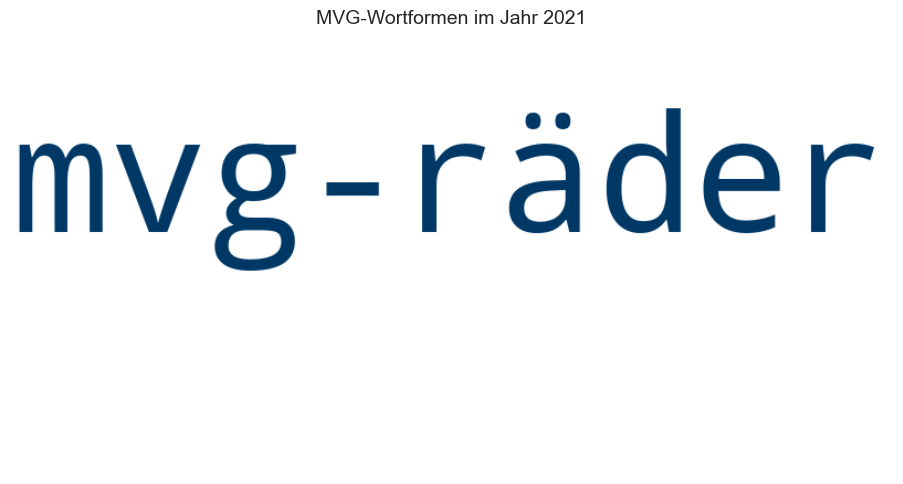

MVG 2022: 5 Wortformen gefunden.


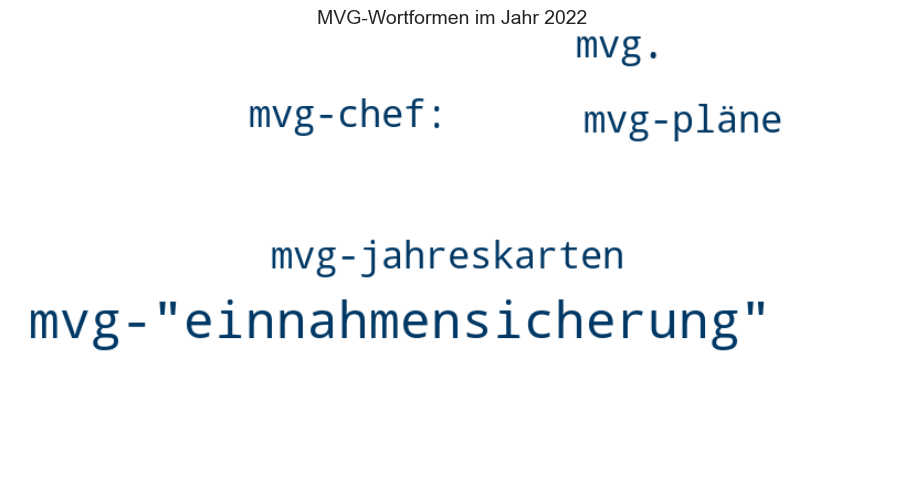

MVG 2023: 3 Wortformen gefunden.


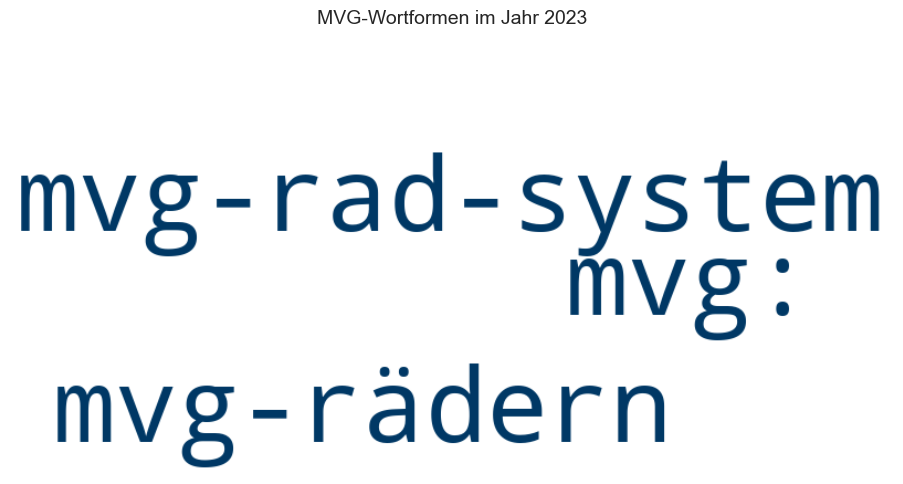

MVG 2024: 2 Wortformen gefunden.


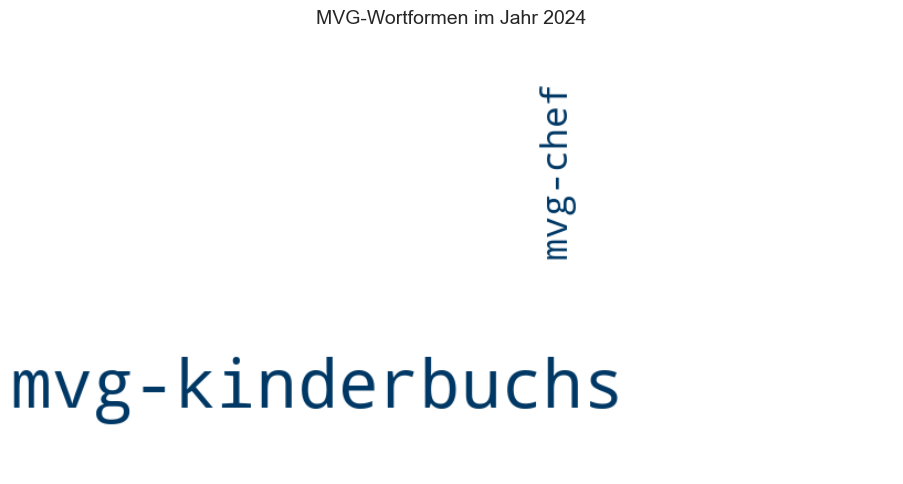

HVV 2021: 10 Wortformen gefunden.


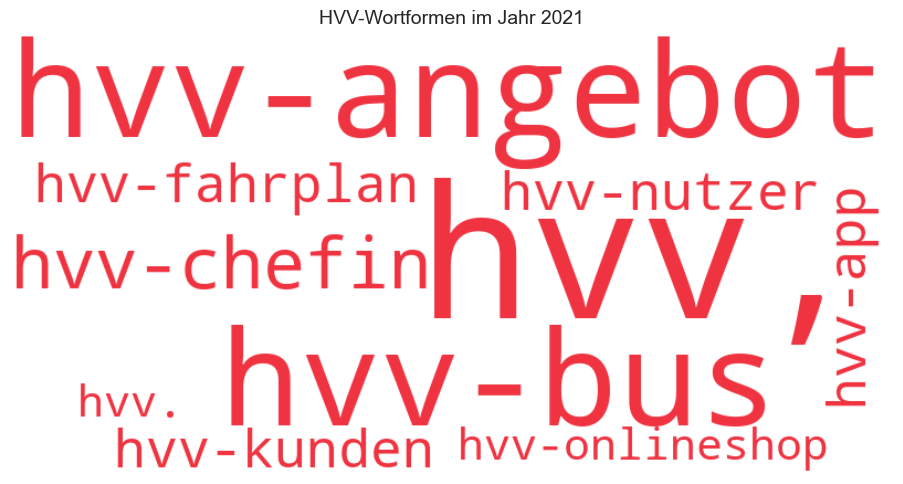

HVV 2022: 17 Wortformen gefunden.


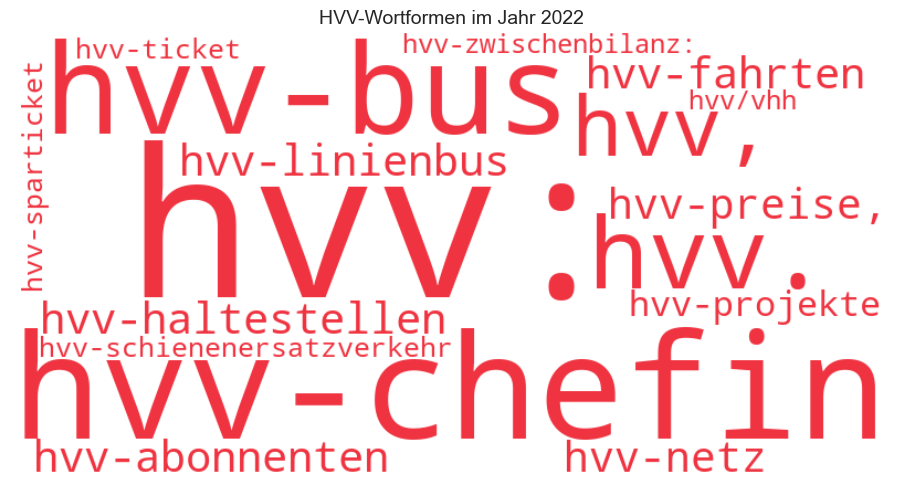

HVV 2023: 18 Wortformen gefunden.


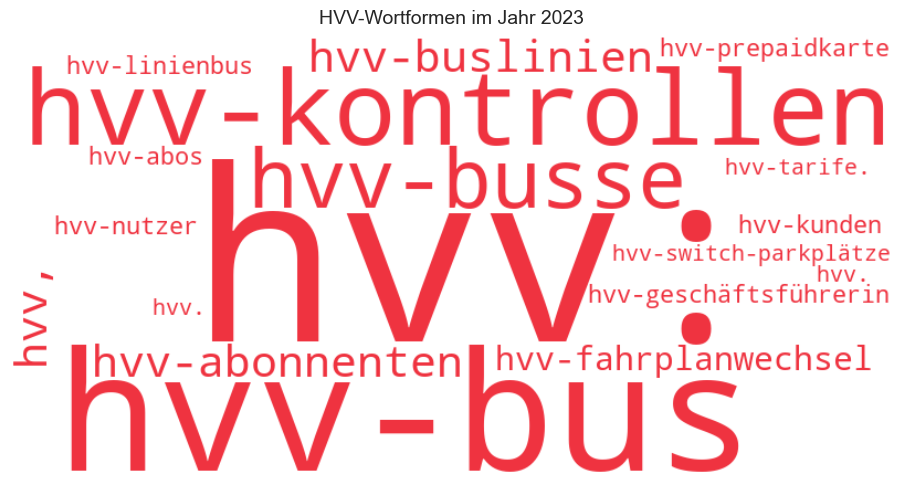

HVV 2024: 20 Wortformen gefunden.


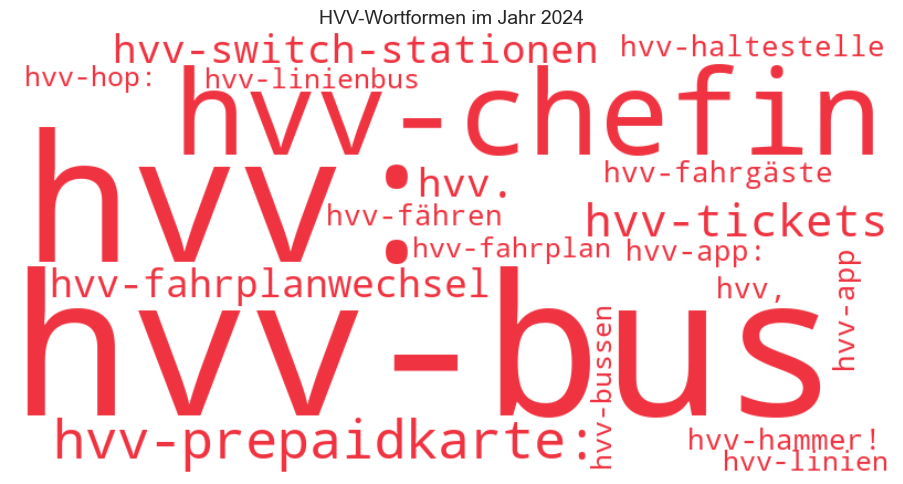

HVV 2025: 7 Wortformen gefunden.


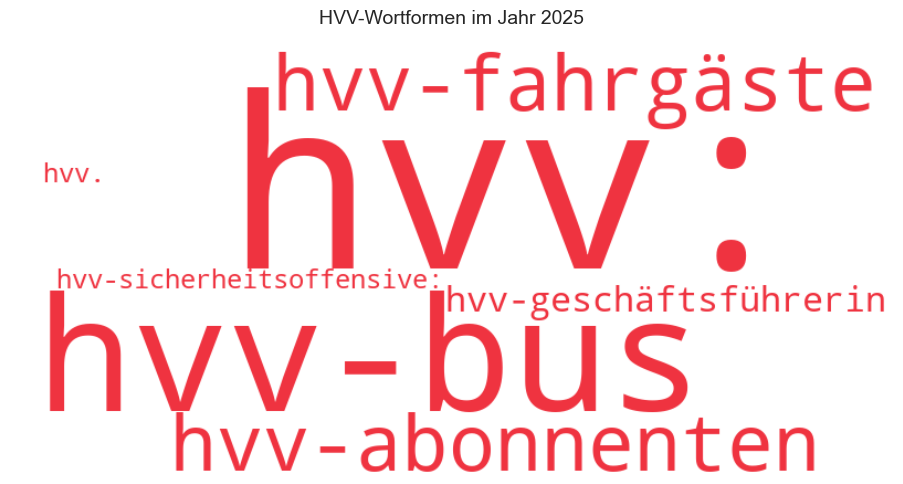

In [72]:
# Plot: Wordclouds für Wortformen, die mit BVG, MVG oder HVV beginnen pro Jahr
# Vorbereitung
# Liste der Jahre
jahre = sorted(df_medien["year"].dropna().unique().astype(int))

# Schleife über Begriffe und Jahre
for begriff in begriffsliste:
    for jahr in jahre:
        # Filter: Wortformen, die mit dem Begriff beginnen (aber nicht exakt der Begriff sind)
        df_wortformen = df_medien[
            (df_medien["word"].str.startswith(begriff, na=False)) &
            (df_medien["word"] != begriff) &
            (df_medien["year"] == jahr)
        ]

        # Wenn es keine Daten gibt, nächsten Jahrgang überspringen
        if df_wortformen.empty:
            continue

        # Häufigkeit der Wortformen berechnen
        wortformen = df_wortformen.groupby("word")["count"].sum().sort_values(ascending=False).head(50)
        wort_dict = wortformen.to_dict()

        # Wordcloud erzeugen
        farbe = farben.get(begriff, "#000000")
        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color="white",
            color_func=lambda *args, **kwargs: farbe
        ).generate_from_frequencies(wort_dict)

        # Plot Formatierung: Titel, Achsen, Layout 
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"{begriff.upper()}-Wortformen im Jahr {jahr}", fontsize=14)
        # Anzahl Wortformen anzeigen
        print(f"{begriff.upper()} {int(jahr)}: {len(wortformen)} Wortformen gefunden.")
        plt.tight_layout()
        plt.show()

In [73]:
# Top-Wortformen pro Cluster für BVG 
analyse_wortformen(df_medien, suchwort="bvg")


Top-Wortformen mit 'bvg' in Cluster: Digital


,cluster,word,count
0,Digital,bvg,16
1,Digital,bvg-beschäftigte,1
2,Digital,bvg-bus,1
3,Digital,bvg-chef:,1
4,Digital,bvg-fundbüro,1
5,Digital,bvg-streit,1
6,Digital,bvg-warnstreik,1
7,Digital,bvg:,1



Top-Wortformen mit 'bvg' in Cluster: Große Medien


,cluster,word,count
10,Große Medien,bvg,139
12,Große Medien,"bvg,",7
29,Große Medien,bvg-tarifkonflikt,6
39,Große Medien,bvg:,6
38,Große Medien,bvg.,5
37,Große Medien,bvg-warnstreik,4
9,Große Medien,(bvg),3
28,Große Medien,bvg-streik,3
14,Große Medien,bvg-angestellte,2
17,Große Medien,bvg-chef,2



Top-Wortformen mit 'bvg' in Cluster: Regional


,cluster,word,count
45,Regional,bvg,1963
222,Regional,bvg:,256
76,Regional,bvg-bus,102
186,Regional,bvg-streik,89
89,Regional,bvg-bussen,82
221,Regional,bvg.,67
188,Regional,bvg-streik:,37
49,Regional,"bvg,",31
88,Regional,bvg-busse,28
96,Regional,bvg-chefin,28



Top-Wortformen mit 'bvg' in Cluster: Technologie


,cluster,word,count
235,Technologie,bvg-app,55
234,Technologie,bvg-account,36
236,Technologie,bvg-fahrinfo-app,26
233,Technologie,bvg,13
238,Technologie,bvg:,2
232,Technologie,(bvg),1
237,Technologie,bvg-klausel.,1



Top-Wortformen mit 'bvg' in Cluster: Wirtschaft


,cluster,word,count
242,Wirtschaft,bvg-chefin,13
240,Wirtschaft,bvg,8
239,Wirtschaft,(bvg),2
241,Wirtschaft,bvg-chef,1
243,Wirtschaft,bvg-urteil,1



Top-Wortformen mit 'bvg' in Cluster: Öffentlich-rechtlich


,cluster,word,count
245,Öffentlich-rechtlich,bvg-direktor,3
247,Öffentlich-rechtlich,bvg-urteil,3
244,Öffentlich-rechtlich,bvg,1
246,Öffentlich-rechtlich,bvg-tarifstreit,1


In [74]:
# Top-Wortformen pro Cluster für HVV 
analyse_wortformen(df_medien, suchwort="hvv")


Top-Wortformen mit 'hvv' in Cluster: Digital


,cluster,word,count
0,Digital,hvv,3
1,Digital,hvv-zwischenbilanz:,1
2,Digital,hvv:,1



Top-Wortformen mit 'hvv' in Cluster: Große Medien


,cluster,word,count
8,Große Medien,hvv:,9
3,Große Medien,hvv,8
6,Große Medien,hvv-chefin,7
4,Große Medien,"hvv,",1
5,Große Medien,hvv-abonnenten,1
7,Große Medien,hvv-tarife.,1



Top-Wortformen mit 'hvv' in Cluster: Regional


,cluster,word,count
12,Regional,hvv,796
19,Regional,hvv-bus,31
55,Regional,hvv:,27
23,Regional,hvv-chefin,6
13,Regional,"hvv,",5
53,Regional,hvv.,5
52,Regional,hvv.,4
26,Regional,hvv-fahrplanwechsel,3
34,Regional,hvv-kontrollen,3
37,Regional,hvv-linienbus,3


In [75]:
# Top-Wortformen pro Cluster für MVG 
analyse_wortformen(df_medien, suchwort="mvg")


Top-Wortformen mit 'mvg' in Cluster: Digital


,cluster,word,count
0,Digital,"""mvg""",8
1,Digital,"""mvg""-heimspiel",1
2,Digital,mvg,1



Top-Wortformen mit 'mvg' in Cluster: Große Medien


,cluster,word,count
3,Große Medien,mvg,24
4,Große Medien,"mvg-""einnahmensicherung""",2
5,Große Medien,mvg-chef,1
6,Große Medien,mvg-chef:,1
7,Große Medien,mvg-jahreskarten,1
8,Große Medien,mvg-pläne,1
9,Große Medien,mvg-rad-system,1
10,Große Medien,mvg-räder,1
11,Große Medien,mvg-rädern,1
12,Große Medien,mvg.,1



Top-Wortformen mit 'mvg' in Cluster: Technologie


,cluster,word,count
14,Technologie,(mvg),2



Top-Wortformen mit 'mvg' in Cluster: Wirtschaft


,cluster,word,count
16,Wirtschaft,mvg,116
17,Wirtschaft,mvg-kinderbuchs,15
15,Wirtschaft,(mvg),3
